# Analying Oil Futures Market

The goal is to quantitative insights into crude oil price behavior and market dynamics, to support trading decisions and risk management.

In [41]:
#importing base packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

1. Find relevant data and process it

2. Price & Volatility Analysis

- Analyze historical price trends using continuous futures data (daily OHLC)

- Calculate rolling volatility (e.g., 30-day, 90-day) and identify volatility regimes

- Compute return distributions over different time scales (daily, weekly, monthly)

3. Roll Yield Approximation

- Estimate roll yield behavior using price changes in continuous futures

- Understand impact of contango/backwardation dynamics indirectly from data

4. Event Studies

- Identify seasonal patterns and correlations with key economic events

- Analyze price/volatility reaction around major oil market events (OPEC meetings, geopolitical shocks)

5. Strategy Development & Backtesting

- Prototype simple trading or hedging strategies (momentum, mean reversion, volatility breakout) based on continuous futures data

- Backtest strategies and evaluate performance metrics (returns, Sharpe ratio, drawdown)

6. Reporting & Visualization

- Create dashboards or notebooks to visualize key insights (price, volatility, returns, event impacts)

- Summarize findings in clear, business-oriented reports with actionable recommendations

## Data Retrieving and Processing

In [ ]:
#use a script created to fetch yfinance data

#get to the path

#check where the script function is located
import os
print(os.getcwd())
print(os.listdir('../../scripts'))

#get to the helper function
import sys
sys.path.append('../../scripts')
#import the function
from fetch_yf_data import fetch_data

#now we can call fetch_data to get data from yf API

c:\Users\dgalassi\commodity_lab\projects\oil_analysis
['.gitkeep', 'data_loader.py', 'fetch_yf_data.py', 'setup_db.py', 'update_commodities_data.py', 'upload_db.py', '__pycache__']


In [6]:
#define the ticker/tickers we want to extract. For now only oil futures (CL=F)

#inputs to the function
tickers = {'Oil':'CL=F'}
period = '20y' # 20 years of data
interval = '1d' #we want daily timeframe

data = fetch_data(tickers,period=period,interval=interval)

Fetching  data for Oil (CL=F) - Period: 20y, Interval: 1d


c:\Users\dgalassi\commodity_lab\projects\oil_analysis\../../scripts\fetch_yf_data.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


In [29]:
#now we extracted the data from yf.
#the script created will extract and automatically format it into a nice table with colums

#some stuff so that the user can have an idea of what the data is about
column_names = []
for col in data.columns:
    column_names.append(col)

print('---------------- Main info about the data ----------------')

print(f'The dataframe has {data.shape[0]} rows and {data.shape[1]} columns ')
print(f'The dataframe spans from {data.date.iloc[0]} to {data.date.iloc[-1]} with timeframe of {interval[0]} day')
print(f'The dataframe contains the following columns:{column_names}')

print('----------------------------------------------------------')

print('You can visualize the first rows of the Dataframe...')
data.head()

---------------- Main info about the data ----------------
The dataframe has 5032 rows and 10 columns 
The dataframe spans from 2005-07-18 00:00:00 to 2025-07-18 00:00:00 with timeframe of 1 day
The dataframe contains the following columns:['date', 'open', 'high', 'low', 'close', 'volume', 'name', 'ticker', 'source', 'timeframe']
----------------------------------------------------------
You can visualize the first rows of the Dataframe...


,date,open,high,low,close,volume,name,ticker,source,timeframe
0,2005-07-18,58.000000,58.980000,56.799999,57.320000,76097,Oil,CL=F,yfinance,1d
1,2005-07-19,57.250000,57.770000,56.799999,57.459999,85894,Oil,CL=F,yfinance,1d
2,2005-07-20,57.380001,58.299999,56.099998,56.720001,145901,Oil,CL=F,yfinance,1d
3,2005-07-21,58.150002,58.169998,56.500000,57.130001,106235,Oil,CL=F,yfinance,1d
4,2005-07-22,57.270000,58.700001,57.130001,58.650002,83067,Oil,CL=F,yfinance,1d


In [85]:
#now let's only keep what we need
print('------------ Reduce to necessary data ---------------')


df = data.drop(['ticker','source','timeframe','open','low','high','name'],axis=1)

print(f'Make sure there are no missing data ...')
print(f'{df.isna().sum()}')

df.head()

------------ Reduce to necessary data ---------------
Make sure there are no missing data ...
date      0
close     0
volume    0
dtype: int64


,date,close,volume
0,2005-07-18,57.320000,76097
1,2005-07-19,57.459999,85894
2,2005-07-20,56.720001,145901
3,2005-07-21,57.130001,106235
4,2005-07-22,58.650002,83067


## Price & Volatility Analysis

The main goal of this substage is to check the price and volatility evolution, and the distribution of returns over different timeframes

Text(0.5, 1.0, 'WTI Futures Closing Daily Price')

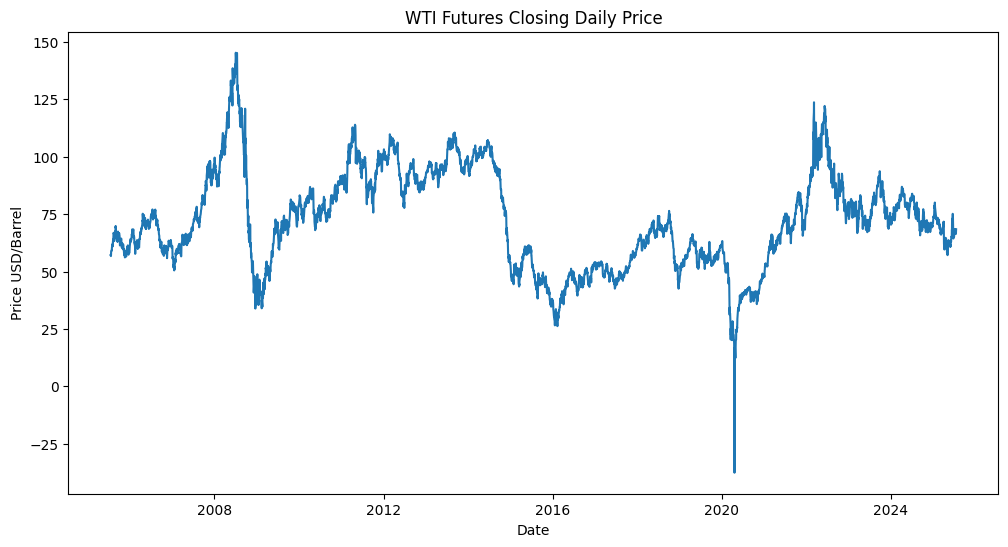

In [86]:
# oil price trend 
plt.figure(figsize=(12,6))
plt.plot(df.date,df.close)
plt.xlabel('Date')
plt.ylabel('Price USD/Barrel')
plt.title('WTI Futures Closing Daily Price')

By observing this plot we realize that during COvid-19 Oil Shock future prices went below 0 USD/Barrel. Is this even a thing?

Normally speaking, when we analyze price movements of bonds or equities, an asset price can't go below zero. This is not true for futures. Future prices, especially for physical commodities, take into account the cost of carry. This cost represents the cost of storing a given commodity, plus the interest paid on the storage plus eventual insurances that seller has to stipulate to cover any potential risk. 

So a future price below zero means that sellers were literally paying buyers to take oil off their reserves. This means that buyers could get the underlying and money to take the oil itself.

This happened for the following reasons?

- Massive oversupply (mostly due to a demand shortage)
- Noone wanted the underlying to be delivered and the contract was about to expire 
- Storage full
- Thin liquidity as most traders already rolled over the next contract 


Later on we could focus on specific events and draw some insighful concluslion!

In [87]:
# Daily (dr), Weekly (wr), Monthly (mr), Querterly (qr), and Yearly (yr) Returns
df['dr'] = np.log(df.close/df.close.shift(1))
df['wr'] = np.log(df.close/df.close.shift(5))
df['mr'] = np.log(df.close/df.close.shift(21))
df['qr'] = np.log(df.close/df.close.shift(63))
df['yr'] = np.log(df.close/df.close.shift(252))

returns = df[['dr','wr','mr','qr','yr']]
print(f'-------------- Main Statistics for Daily (dr), Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Returns ----------------')
returns.describe()

-------------- Main Statistics for Daily (dr), Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Returns ----------------


c:\Users\dgalassi\commodity_lab\env_commodity_lab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgalassi\commodity_lab\env_commodity_lab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgalassi\commodity_lab\env_commodity_lab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgalassi\commodity_lab\env_commodity_lab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgalassi\commodity_lab\env_commodity_lab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dr,wr,mr,qr,yr
count,5029.000000,5025.000000,5009.000000,4967.000000,4778.000000
mean,0.000155,0.000267,0.000346,0.000188,0.003452
std,0.026254,0.056859,0.118799,0.219897,0.375650
min,-0.282206,-0.697633,-0.938142,-1.762703,-1.881514
25%,-0.012361,-0.027626,-0.059225,-0.088452,-0.187211
50%,0.000991,0.003308,0.010002,0.021326,0.020561
75%,0.012886,0.030993,0.068343,0.122547,0.209820
max,0.319634,0.688273,1.207662,1.433132,1.813011


As we discussed before we can observe that the minimum returns are way below -100% due to the pandemic demand driven shock. We can also notice that, as expected, oil can't be considered an asset to buy and hold as the median and mean returns are very low. Lately we will analyze more in depth the returns distributions for different time horizions

Text(0.5, 1.0, 'Monthly Price Log Returns (%)')

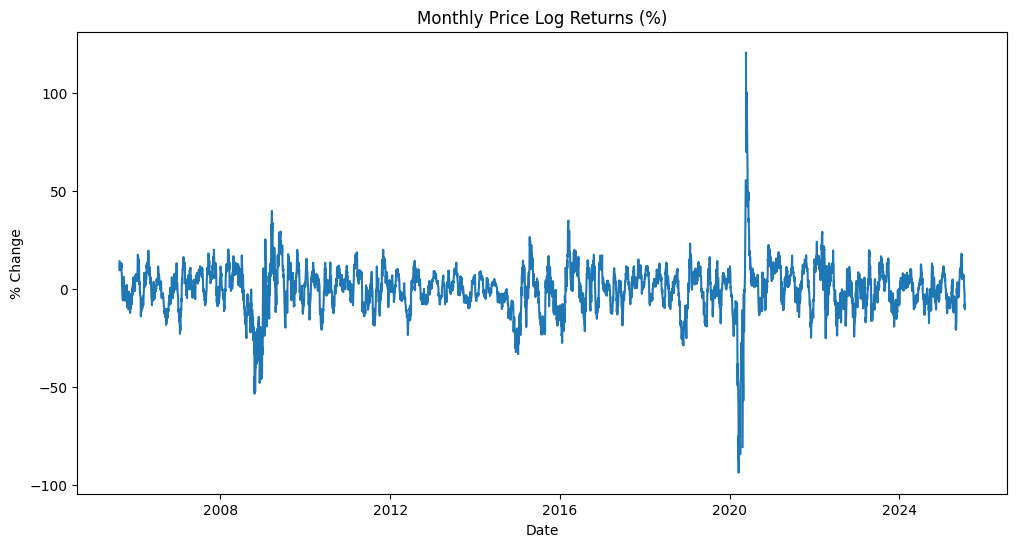

In [88]:
plt.figure(figsize=(12,6))
plt.plot(df.date,df.mr*100)
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('Monthly Price Log Returns (%)')

To have a braoder idea of the returns over different time horizons we observe their distributions in the following chart 

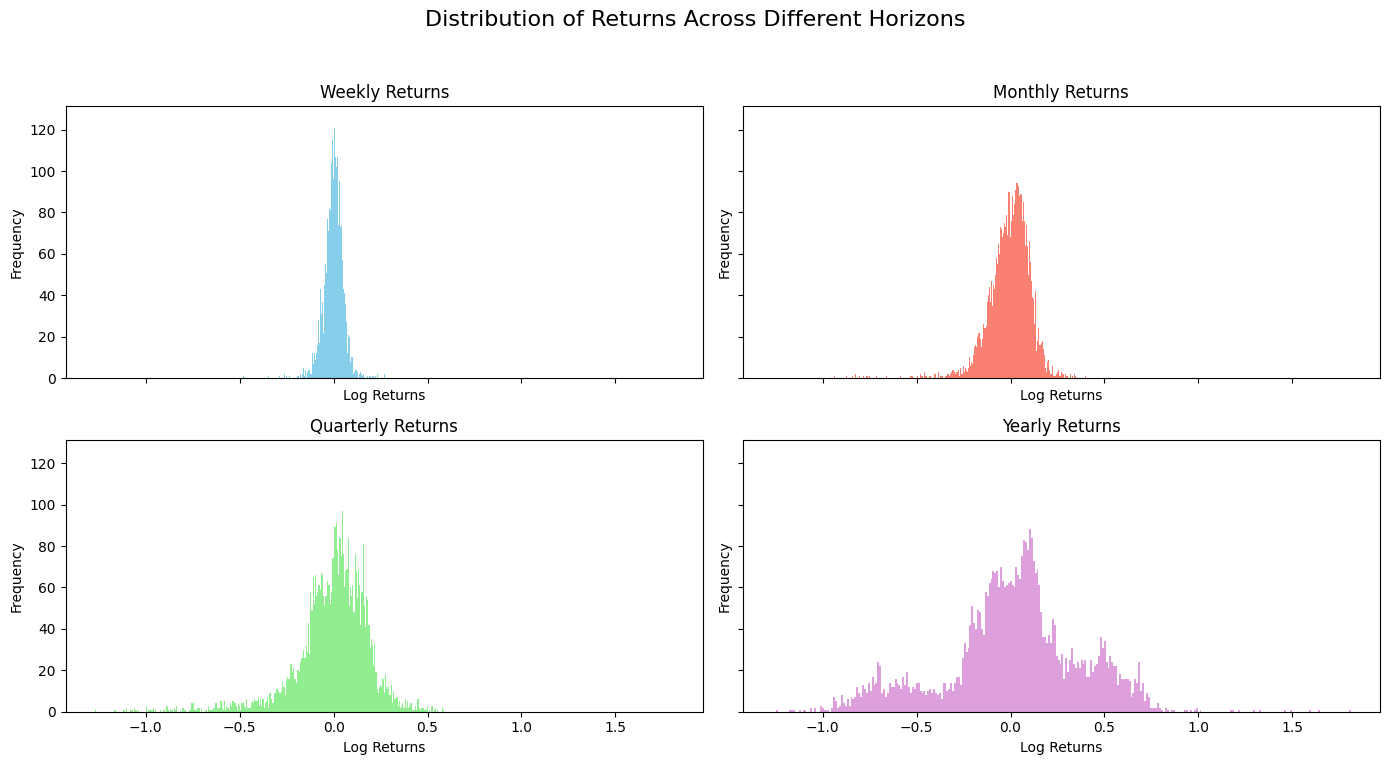

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

axs[0, 0].hist(df.wr.dropna(), bins=300, color='skyblue')
axs[0, 0].set_title('Weekly Returns')

axs[0, 1].hist(df.mr.dropna(), bins=300, color='salmon')
axs[0, 1].set_title('Monthly Returns')

axs[1, 0].hist(df.qr.dropna(), bins=300, color='lightgreen')
axs[1, 0].set_title('Quarterly Returns')

axs[1, 1].hist(df.yr.dropna(), bins=300, color='plum')
axs[1, 1].set_title('Yearly Returns')

# Shared labels
for ax in axs.flat:
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Frequency')

plt.suptitle('Distribution of Returns Across Different Horizons', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [89]:
# Weekly (wrv), Monthly (mrv), Quarterly (qrv) and Yearly (yrv) Rolling Volatility 

#based on daily returns!!! so it is day to day rolled over the periods cited above

df['wrv'] = df.dr.rolling(5).std()
df['mrv'] = df.dr.rolling(21).std()
df['qrv'] = df.dr.rolling(63).std()
df['yrv'] = df.dr.rolling(252).std()

rolling_vol = df[['wrv','mrv','qrv','yrv',]]
print(f'-------------- Main Statistics for Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Rolling Volatility ----------------')
rolling_vol.describe()

-------------- Main Statistics for Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Rolling Volatility ----------------


,wrv,mrv,qrv,yrv
count,5021.000000,4989.000000,4905.000000,4527.000000
mean,0.020859,0.021796,0.021916,0.022344
std,0.015532,0.012130,0.009553,0.007711
min,0.001539,0.006314,0.007509,0.010141
25%,0.011901,0.014871,0.016011,0.017977
50%,0.017377,0.018742,0.020363,0.020440
75%,0.024823,0.024903,0.024427,0.025375
max,0.227590,0.127133,0.077977,0.047511


Text(0.5, 1.0, 'Monthly (21 trading days) Rolling Volatility')

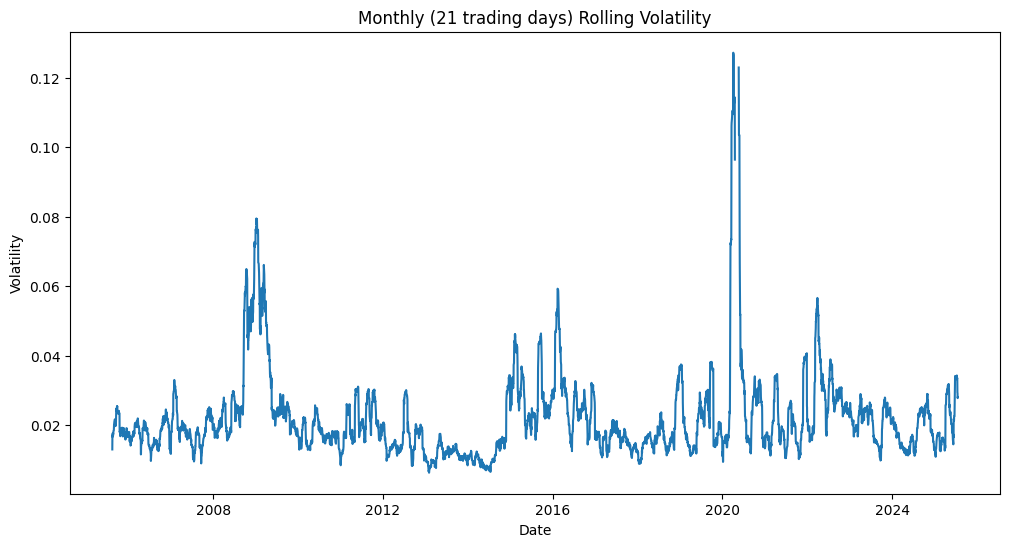

In [90]:
plt.figure(figsize=(12,6))
plt.plot(df.date,df.mrv)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Monthly (21 trading days) Rolling Volatility')

I want to categorize periods based on the monthly (21 trading days) rolled volatility. To do so we calculate the tertiles (33%th and 66%th quantiles).

Low volatility iff < 33%th quantile
Medium volatility iff >= 33%th quantile and <66%th quantile
High volatility iff >=66%th quantile

The following plot shows how graphically teh data is categoried based on the verdical dotted lines!!!

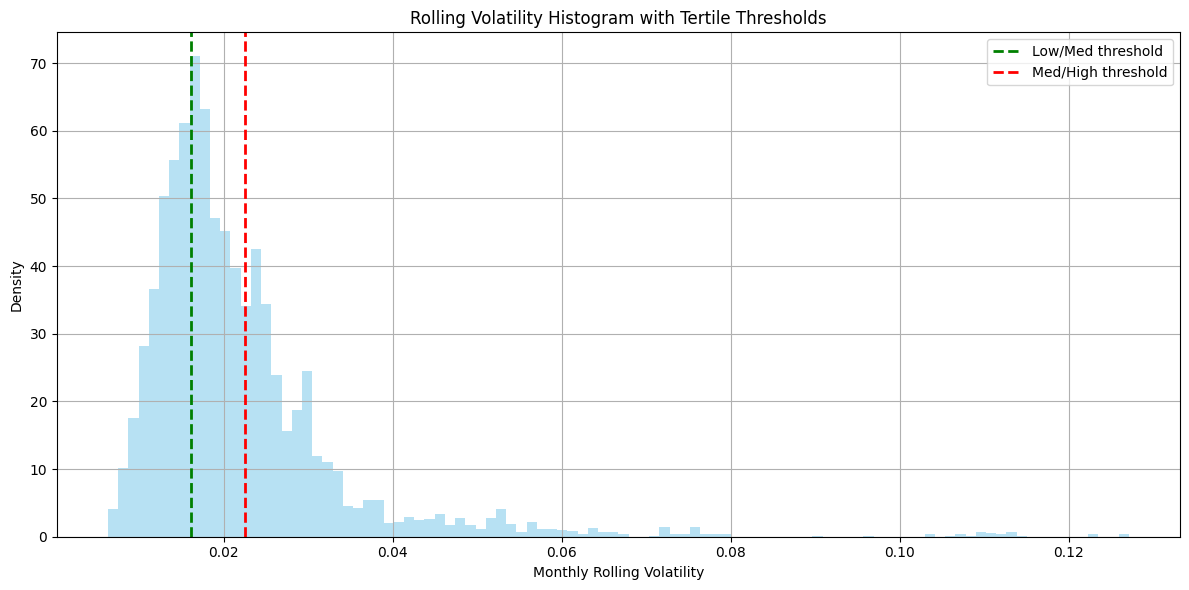

In [97]:
#calculating distribution tertiles
low_vol = df.mrv.quantile(0.33) #first tertile limit
high_vol = df.mrv.quantile(0.66) #second tertile limit

plt.figure(figsize=(12, 6))
plt.hist(df.mrv, bins=100, density=True, alpha=0.6, color='skyblue')
#adding tertiles barriers
plt.axvline(low_vol, color='green', linestyle='--', linewidth=2, label='Low/Med threshold')
plt.axvline(high_vol, color='red', linestyle='--', linewidth=2, label='Med/High threshold')
plt.title("Rolling Volatility Histogram with Tertile Thresholds")
plt.xlabel("Monthly Rolling Volatility")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Little parenthesis.... after all teh calcualtions we are going to have a lot of NaN due to rolling and long horizon returns calculations. Now the df is sufficiently big so we can drop these NaNs...

In [105]:
df = df.dropna()

In [109]:
#the fastest way to do it is this one... 
# ....otherwise a long and inefficient for loop + if, elif, else :)

df['vol_cat'] = pd.qcut(df.mrv, q = 3, labels=['low','medium','high'])

C:\Users\dgalassi\AppData\Local\Temp\ipykernel_15500\2874646170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol_cat'] = pd.qcut(df.mrv, q = 3, labels=['low','medium','high'])


Now, this figure will be more useful later on.. right now let's just visualie it on a chart!

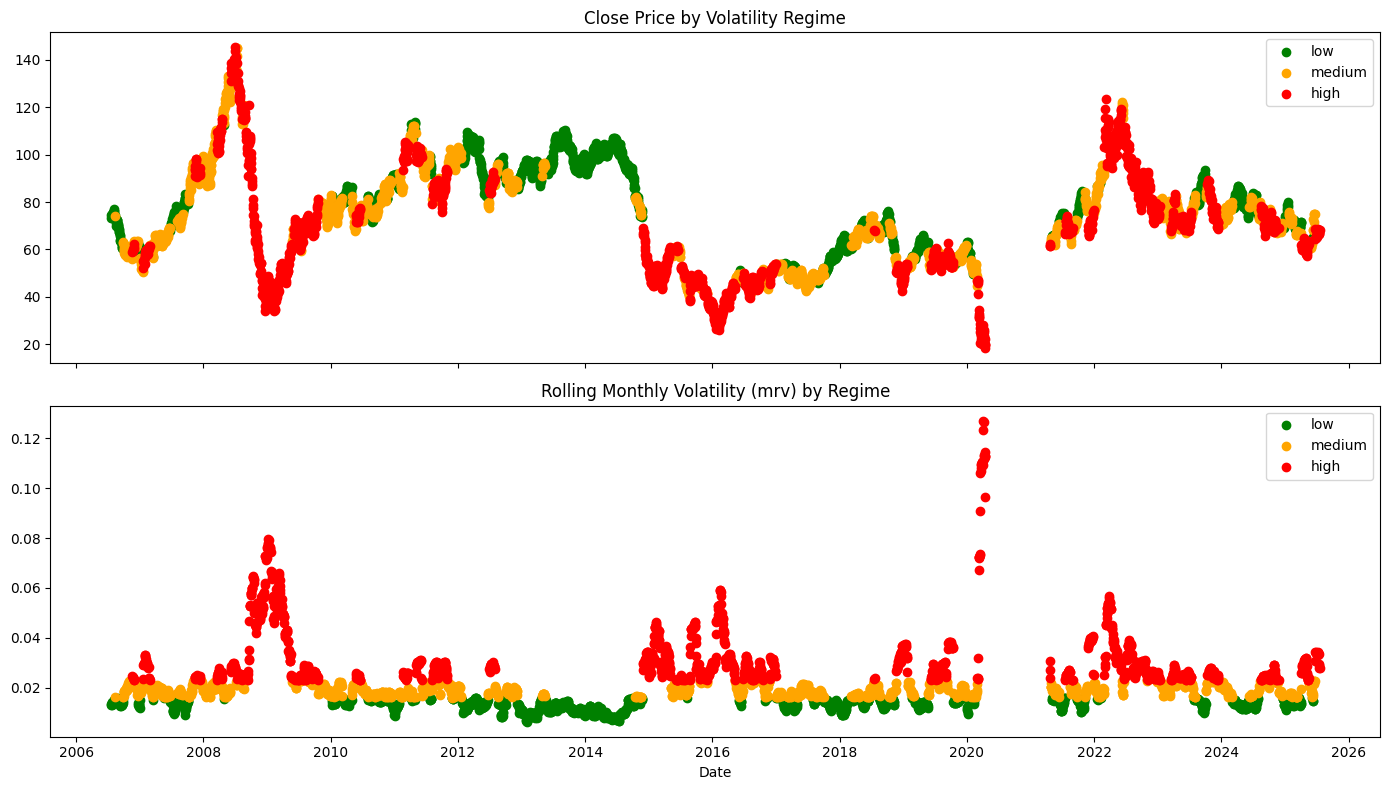

In [ ]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Loop over categories and plot each segment separately
for cat, color in colors.items():
    segment = df[df['vol_cat'] == cat]
    
    # Plot close price
    axs[0].scatter(segment.date, segment['close'], color=color, label=cat, )
    
    # Plot rolling vol (mrv)
    axs[1].scatter(segment.date, segment['mrv'], color=color, label=cat)

# Add titles and legends
axs[0].set_title('Close Price by Volatility Regime')
axs[1].set_title('Rolling Monthly Volatility (mrv) by Regime')
axs[1].set_xlabel('Date')

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


## Roll Yield Approximation

To analyze roll yield properly we would need differnt data. Indeed, the roll yield is defined as the return we get by rolling a futures contract overtime. This means closing the near-term contract and opening a longer-term contract. 

Now if the market is backwardation (F<S) we expect an inverted curve. Hence, rolling will ensure us selling the near term at higher price than the amount we are paying for the longer term contract. Hence the roll yield is positive (the opposite occurs in contango).

As we said, we don not have closing prices for each contract so we need a proxy to analyze this!